In [364]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.integrate import quad

from time import perf_counter as time
from tqdm import tqdm
from scipy import linalg

# 1a

In [149]:
def u(x): return 1/(2 - np.cos(x))

M = 200
x_array = np.linspace(0, 2*np.pi, M)

N = 100
n_array = np.arange(-N, N+1)
denominator = np.sqrt(3) * ((2 + np.sqrt(3))**(np.abs(n_array)))
cn = 1/denominator

A_fourier = np.exp(1j * x_array[:, None] * n_array[None, :])
B = (A_fourier * cn[None, :])
f_x = np.sum(B, axis = 1)
print(B.shape, cn.shape, f_x.shape)

resid = u(x_array) - f_x

(200, 201) (201,) (200,)


In [150]:
resid_array = np.zeros((N-1, M))
for i in range(N - 1):
    i_left, i_right = N - i - 1, N + i + 1
    resid_array[i, :] = u(x_array) - np.sum(B[:, i_left:(i_right+1)], axis=1)

print(resid_norm.shape)
resid_norm = np.linalg.norm(resid_array, axis = 1)

(9,)


/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_55716/2151121164.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  resid_array[i, :] = u(x_array) - np.sum(B[:, i_left:(i_right+1)], axis=1)


/opt/anaconda3/envs/scicom/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/scicom/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


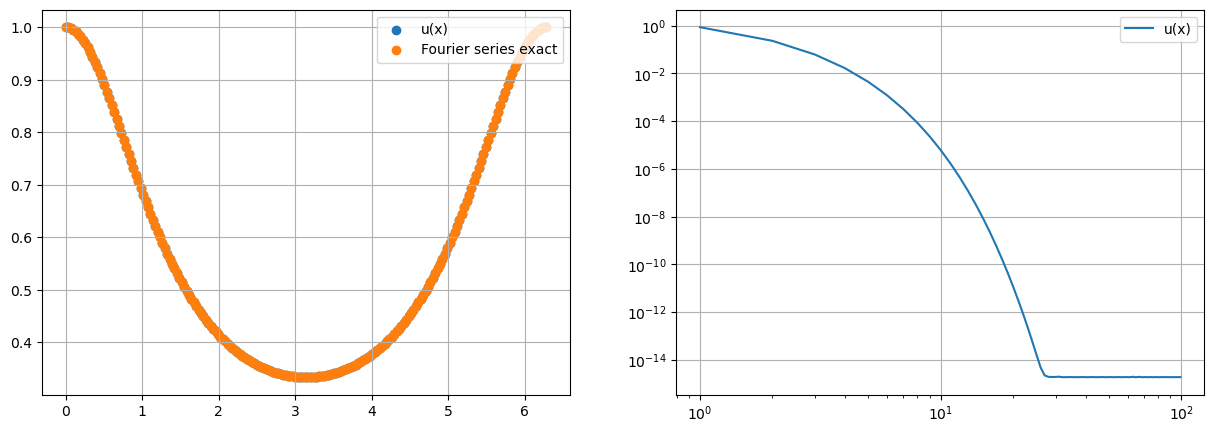

In [151]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].scatter(x_array, u(x_array), label = "u(x)")
ax[0].scatter(x_array, f_x, label = "Fourier series exact")
ax[0].legend(loc = "upper right")
ax[0].grid()
ax[1].loglog(np.arange(1, N), resid_norm, label = "u(x)")
ax[1].legend(loc = "upper right")
ax[1].grid()

# 1b

In [155]:
dft_array = np.zeros((N-1, M), dtype = complex)
for N_dft in range(N - 1):
    dft_components = np.fft.fftshift(np.fft.fft(a = u(x_array), n = 2*N_dft + 1, norm = "forward"))
    # print(dft_components.shape)

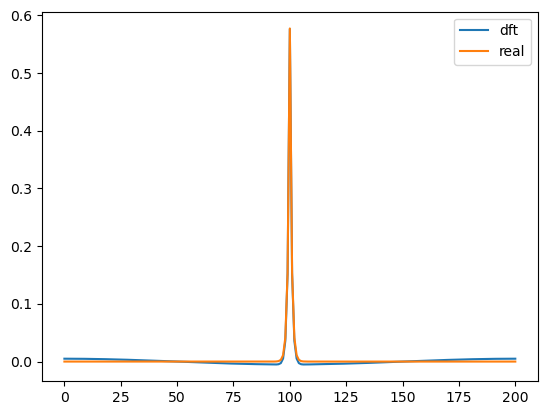

In [153]:
plt.plot(dft_components.real, label = "dft")
plt.plot(cn, label = "real")
plt.legend()

# 1c

In [4]:
N = 6
h = 2*np.pi / N
x_array = np.arange(N) * h
print(x_array)

[0.         1.04719755 2.0943951  3.14159265 4.1887902  5.23598776]


In [6]:
def lagrange_polynomial(xj, x, N):
    return (1/N)*(np.sin((N/2)*(x - xj)) * np.cos((x - xj)/2) / np.sin((x - xj)/2))

/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_14323/3452291567.py:2: RuntimeWarning: invalid value encountered in divide
  return (1/N)*(np.sin((N/2)*(x - xj)) * np.cos((x - xj)/2) / np.sin((x - xj)/2))


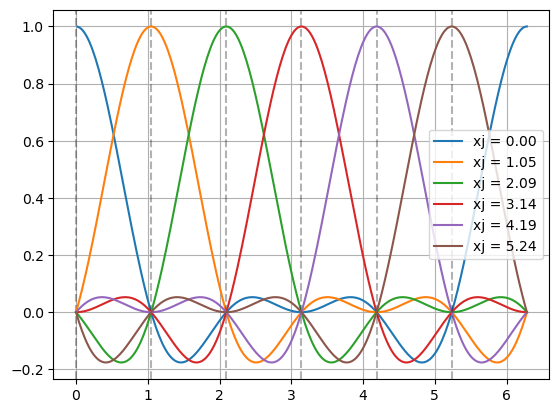

In [11]:
x_plot = np.linspace(0, 2*np.pi, 300)

for xj in x_array:
    plt.plot(x_plot, lagrange_polynomial(xj = xj, x = x_plot, N = N), label = f"xj = {xj:.2f}")
    plt.axvline(x = xj, color = "k", linestyle = "--", alpha = 0.3)
plt.grid()
plt.legend()
plt.show();

In [36]:
def f_test(x):
    return x*(2*np.pi - x)

def I_N(x, x_array):
    u_array = f_test(x_array)
    result = np.zeros(shape = (x_array.shape[0], x.shape[0]))
    for j, xj in enumerate(x_array):
        result[j, :] = u_array[j] * lagrange_polynomial(xj = xj, x = x, N = len(x_array))
    return result

u_array = f_test(x_array)
X = I_N(x = x_plot, x_array = x_array)
f_lagrange = np.sum(X, axis = 0)

/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_14323/3452291567.py:2: RuntimeWarning: invalid value encountered in divide
  return (1/N)*(np.sin((N/2)*(x - xj)) * np.cos((x - xj)/2) / np.sin((x - xj)/2))


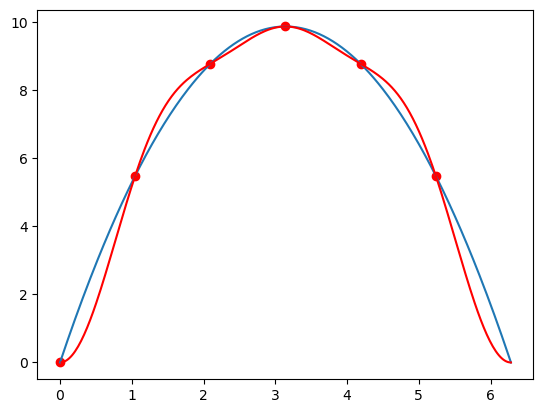

In [37]:
plt.plot(x_plot, f_test(x_plot))
plt.scatter(x_array, u_array, color = "red")
plt.plot(x_plot, f_lagrange, color = "red")

## 1d

In [272]:
# def h_jk(k, j): return 1/2 * (-1)**(np.abs(k + j)) * np.cos(1/N * np.pi * (np.abs(j - k))) / np.sin(1/N * np.pi * (np.abs(j - k)))
def h_jk(k, j, N_input):
    diff = k - j
    return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)

def get_D(N_input, index_array = None):
    if index_array is None:
        index_array = np.arange(N_input)
    D_deriv = h_jk(k = index_array[:, None], j = index_array[None, :], N_input = N_input)
    np.fill_diagonal(D_deriv, 0.0)
    return D_deriv

In [ ]:
N = 10
# def v(x): return np.exp(np.sin(x))
# def dv(x): return np.exp(np.sin(x)) * np.cos(x)

def v(x): return np.cos(x)
def dv(x): return -np.sin(x)

# def v(x): return np.cos(x)*np.where(x < 0, -1, 1) 
# def dv(x): return np.sin(x)*np.where(x < 0, 1, -1)

h = 2*np.pi / N
x_array = np.arange(N) * h

v_array = v(x_array)
dv_array = dv(x_array)

print(v_array)
print(dv_array)

D = get_D(N_input = N)

dv_D = D @ v_array

print(np.linalg.norm(dv_array - dv_D, ord = np.inf))

[ 1.          0.80901699  0.30901699 -0.30901699 -0.80901699 -1.
 -0.80901699 -0.30901699  0.30901699  0.80901699]
[-0.00000000e+00 -5.87785252e-01 -9.51056516e-01 -9.51056516e-01
 -5.87785252e-01 -1.22464680e-16  5.87785252e-01  9.51056516e-01
  9.51056516e-01  5.87785252e-01]
6.938893903907228e-16


/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_14323/3656342784.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)


6.938893903907228e-16


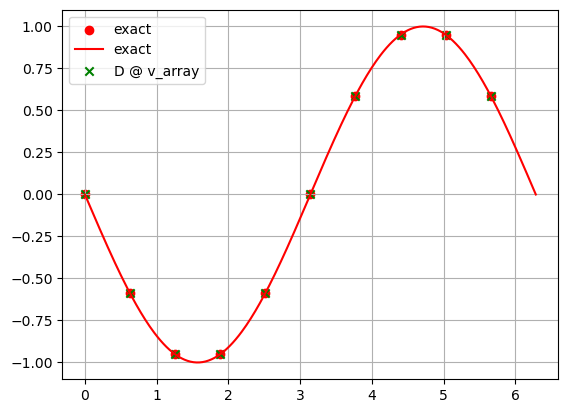

In [263]:
x_plot = np.linspace(0, 2*np.pi, 300)

print(np.linalg.norm(dv_array - dv_D, ord = np.inf))

plt.scatter(x_array, dv_array, label = "exact", color = "red")
plt.plot(x_plot, dv(x_plot), label = "exact", color = "red")
plt.scatter(x_array, dv_D, label = "D @ v_array", marker = "x", color = "green")
plt.legend()
plt.grid();

In [198]:
N_max = 50
N_grid = np.arange(2, N_max, step = 2)

result = np.zeros(shape = N_grid.shape[0])
for i, N_test in enumerate(N_grid):

    indexes_array = np.arange(N_test)
    x_array = indexes_array * 2*np.pi / N_test
    v_array = v(x_array)
    dv_array = dv(x_array)
    
    D = h_jk(k = indexes_array[:, None], j = indexes_array[None, :], N_input = N_test)
    np.fill_diagonal(D, 0.0)

    dv_D = D @ v_array

    # result[i] = np.linalg.norm(dv_array - dv_D, ord = np.inf)
    result[i] = np.linalg.norm(dv_array - dv_D, ord = np.inf)

    # plt.scatter(x_array, dv_array, label = "exact", color = "red")
    # plt.scatter(x_array, dv_D, label = "D @ v_array", marker = "x", color = "green")
    # # plt.title(f"N = {N_text}, error = {result[i]:.2e}")

/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_14323/2867430241.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_14323/3767020429.py:15: RuntimeWarning: divide by zero encountered in matmul
  dv_D = D @ v_array
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_14323/3767020429.py:15: RuntimeWarning: overflow encountered in matmul
  dv_D = D @ v_array
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_14323/3767020429.py:15: RuntimeWarning: invalid value encountered in matmul
  dv_D = D @ v_array


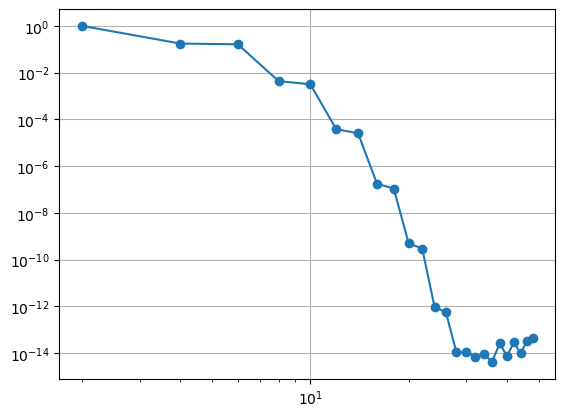

In [199]:
plt.loglog(N_grid, result, marker = "o");
plt.grid();

## 1e

In [ ]:
# Defining functions
def w0(x): return np.cos(x)*np.where(x < 0, -1, 1) 
def w1(x): return np.sin(x)*np.where(x < 0, 1, -1)
# def w2(x): return (np.cos(x) + 1)*np.where(x <= 0, 1, -1)
# def w3(x): return (np.sin(x) + x - 2)*np.where(x <= 0, 1, -1)

N = 10
# x_array = np.arange(N) * 2*np.pi / N
x_array = np.arange(-N, N) * 2*np.pi / N

w0_array = w0(x_array)
w1_array = w1(x_array)
w2_array = w2(x_array)
w3_array = w3(x_array)

D = get_D(N_input = 2*N, index_array=np.arange(-N, N))
# D = get_D(N_input = N)

w1_D = D @ w0_array
w2_D = D @ w1_array
w3_D = D @ w2_array

/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_14323/3656342784.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)


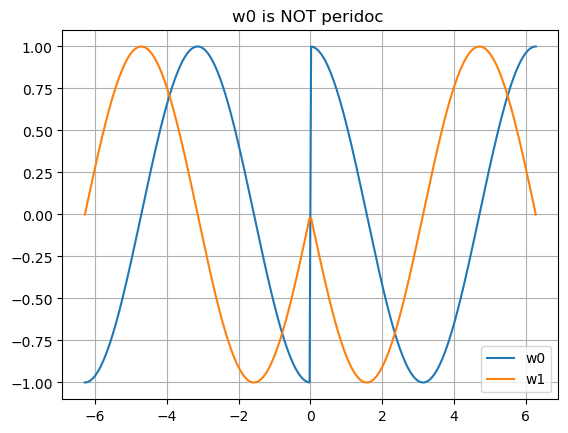

In [298]:
plt.plot(np.linspace(-2*np.pi, 2*np.pi, 300), w0(np.linspace(-2*np.pi, 2*np.pi, 300)), label = "w0")
plt.plot(np.linspace(-2*np.pi, 2*np.pi, 300), w1(np.linspace(-2*np.pi, 2*np.pi, 300)), label = "w1")
plt.legend()
plt.title("w0 is NOT peridoc ")
plt.grid();

In [ ]:
# f = interpolate.interp1d(x_array, w1_D)
# I = quad(integrand, 0, 1, args=(a,b))

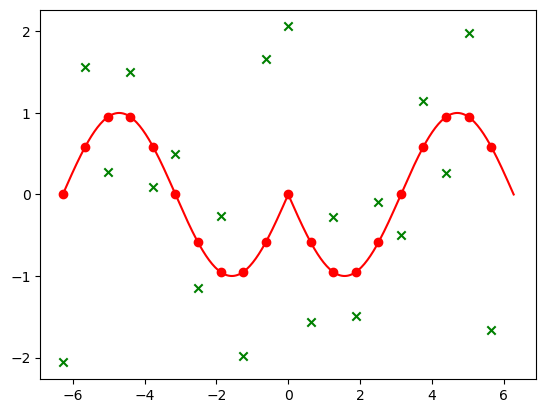

In [296]:
x_plot = np.linspace(-2*np.pi, 2*np.pi, 300)
plt.scatter(x_array, w1_array, label = "exact", color = "red")
plt.plot(x_plot, w1(x_plot), label = "exact", color = "red")
plt.scatter(x_array, w1_D/2, label = "D @ v_array", marker = "x", color = "green")
# plt.legend()
# plt.grid();

## 1f

In [418]:
N = 16
def v(x): return np.exp(np.sin(x))
def dv(x): return np.exp(np.sin(x)) * np.cos(x)

h = 2*np.pi / N
x_array = np.arange(N) * h

v_array = v(x_array)
dv_array = dv(x_array)

D = get_D(N_input = N)
dv_D = D @ v_array

print(np.linalg.norm(dv_array - dv_D, ord = np.inf))

1.76189313139119e-07


/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_14323/3656342784.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)


In [419]:
dft_components = np.fft.fft(v_array, n=N, norm="forward")
diffx_FFT = np.fft.ifft(1j * np.fft.fftshift(np.arange(-N/2, N/2)) * dft_components, norm = "forward")

1.76189313139119e-07


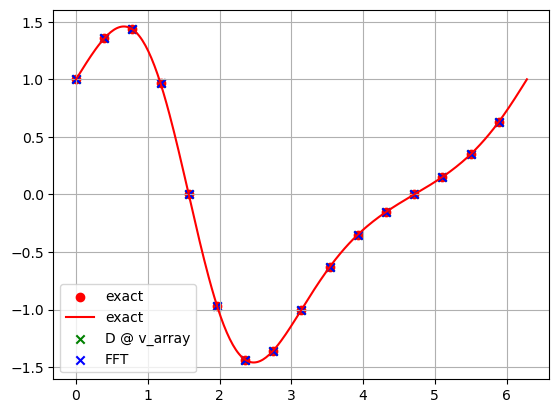

In [420]:
x_plot = np.linspace(0, 2*np.pi, 300)

print(np.linalg.norm(dv_array - dv_D, ord = np.inf))

plt.scatter(x_array, dv_array, label = "exact", color = "red")
plt.plot(x_plot, dv(x_plot), label = "exact", color = "red")
plt.scatter(x_array, dv_D, label = "D @ v_array", marker = "x", color = "green")
plt.scatter(x_array, diffx_FFT.real, label = "FFT", marker = "x", color = "blue")
plt.legend()
plt.grid();

In [396]:
N_max = 100
N_grid = np.logspace(1, 4, num=N_max).astype(int)
N_grid += N_grid % 2

result = np.zeros(shape = (2, N_grid.shape[0]))
times = np.zeros(shape = (2, N_grid.shape[0]))
for i, N_test in tqdm(enumerate(N_grid)):

    indexes_array = np.arange(N_test)
    x_array = indexes_array * 2*np.pi / N_test
    v_array = v(x_array)
    dv_array = dv(x_array)

    start = time()
    D = get_D(N_input = N_test)
    dv_D = D @ v_array
    times[0, i] = time() - start

    start = time()
    dft_components = np.fft.fft(v_array, n=N_test, norm="forward")
    diffx_FFT = np.fft.ifft(1j * np.fft.fftshift(np.arange(-N_test/2, N_test/2)) * dft_components, norm = "forward")
    times[1, i] = time() - start

    result[0, i] = np.linalg.norm(dv_array - dv_D, ord = np.inf)
    result[1, i] = np.linalg.norm(dv_array - diffx_FFT, ord = np.inf)

0it [00:00, ?it/s]/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_14323/3656342784.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_14323/1924241886.py:16: RuntimeWarning: divide by zero encountered in matmul
  dv_D = D @ v_array
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_14323/1924241886.py:16: RuntimeWarning: overflow encountered in matmul
  dv_D = D @ v_array
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_14323/1924241886.py:16: RuntimeWarning: invalid value encountered in matmul
  dv_D = D @ v_array
100it [00:16,  6.02it/s]


In [421]:
def ls(x, y, mask = None):
    x = x[mask]
    y = y[mask]
    A = np.c_[(np.ones(x.shape[0]), x)]
    beta = linalg.solve(A.T @ A, A.T @ y)
    return beta

# X = np.c_[(np.ones(N_grid.shape[0]), np.log(N_grid))]
# considered_obs = N_grid > 50
# X = X[considered_obs, :]
# beta_D = linalg.solve(X.T @ X, X.T @ np.log(times[0, considered_obs]))
# print(beta)

beta_D = ls(np.log(N_grid), np.log(times[0, :]), mask = N_grid > 100)
beta_fft = ls(np.log(N_grid), np.log(times[1, :]), mask = N_grid > 100)

coef_fft = times[1, N_grid > 100] / N_grid[N_grid > 100] * np.log(N_grid[N_grid > 100])
coef_fft = np.mean(np.log(coef_fft))

beta_D = array([-17.83368187,   2.01803721]), beta_fft = array([-14.035914  ,   0.75953877]), coef_fft = np.float64(-13.786641962774599)


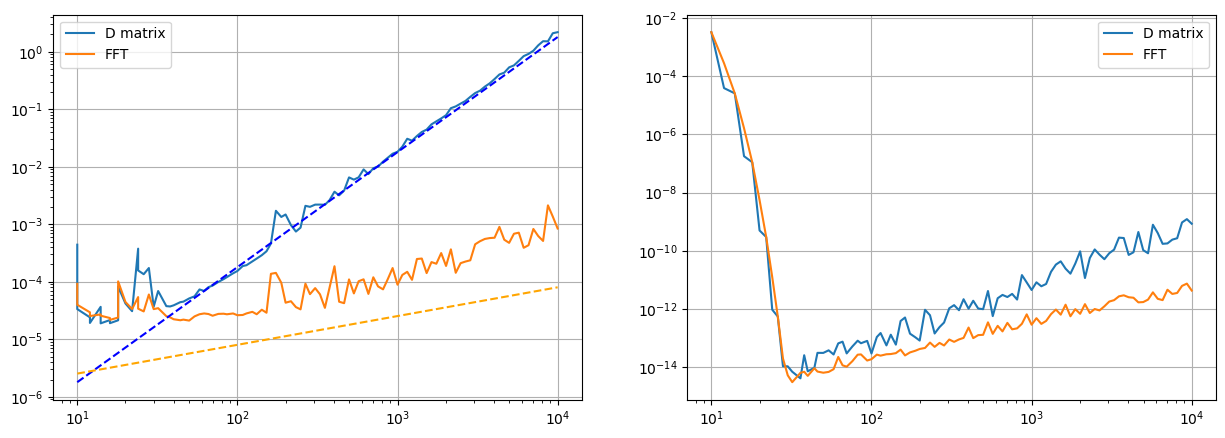

In [422]:
print(f"{beta_D = }, {beta_fft = }, {coef_fft = }")

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].loglog(N_grid, times[0, :], label = "D matrix");
ax[0].loglog(N_grid, times[1, :], label = "FFT");
ax[0].loglog(N_grid, np.exp(beta_D[0])*N_grid**2, linestyle='--', color = "blue")
ax[0].loglog(N_grid, np.exp(beta_fft[0])*N_grid**(1/2), linestyle='--', color = "orange")
# plt.loglog(N_grid, np.exp(coef_fft)*N_grid*np.log(N_grid), linestyle='--', color = "orange")
ax[0].grid();
ax[0].legend();

ax[1].loglog(N_grid, result[0, :], label = "D matrix");
ax[1].loglog(N_grid, result[1, :], label = "FFT");
ax[1].grid();
ax[1].legend();
plt.show();